# Equi Boots Graphical Notebook

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/lshpaner/Documents/GitHub_Repositories/equi_boots/py_scripts


In [2]:
import equiboots as eqb

## Prepping equiboots

### Classification Mock-Up

In [3]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

Groups created


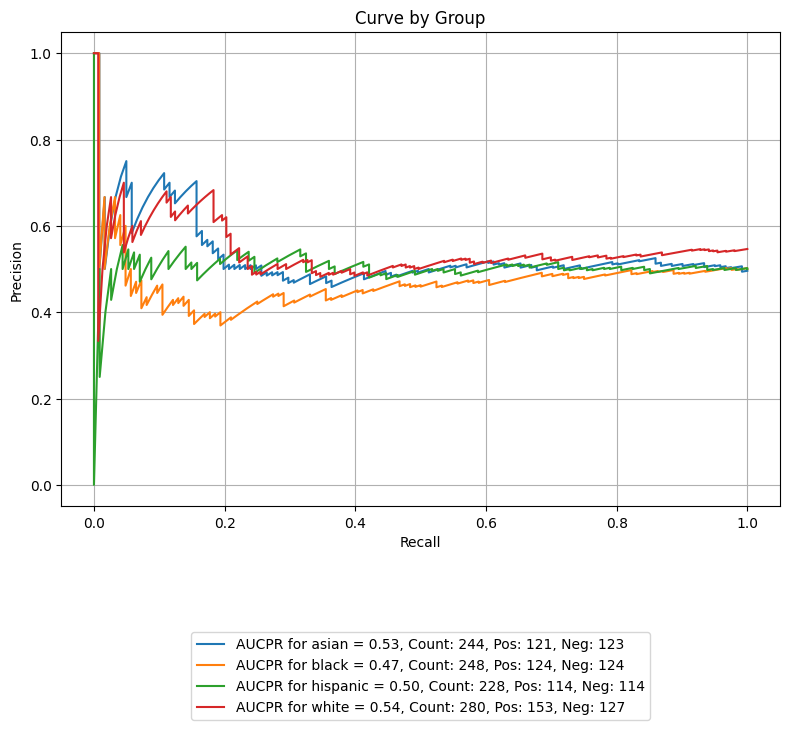

In [4]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    save_path=None,
    filename="group_curve",
    title="Curve by Group",
    figsize=(8, 8),
    # dpi=100,
    # group="black",
    decimal_places=2,
    # subplots=True,
    # n_cols=2,
    # n_rows=None,
    color_by_group=True,
    curve_kwgs=None,
    line_kwgs=None,
    n_bins=10,
)

## ROC AUC by Group (ex. Race)

In [5]:
# eqb.eq_plot_roc_auc(
#     data=sliced_data,
#     # title="ROC Curve by Race",
#     decimal_places=3,
#     save_path="./images",
#     # title=None,
#     # label_fontsize=20,
#     # tick_fontsize=10,
#     color_by_group=True,
#     subplots=True,
#     # group="black",
#     curve_kwgs={
#         "black": {"color": "#FF5733", "alpha": 0.7, "linestyle": "--", "linewidth": 2},
#         "white": {"color": "#1F77B4", "alpha": 0.8, "linewidth": 2},
#     },
#     # line_kwgs={"color": "black", "linestyle": "dotted", "linewidth": 2},
# )

## Precision-Recall Curves

In [6]:
# eqb.eq_plot_precision_recall(
#     data=sliced_data,
#     # title="Precision-Recall Curve by Race",
#     decimal_places=3,
#     save_path="./images",
#     # subplots=True,
#     group="black",
#     curve_kwgs={
#         "black": {"color": "#FF5733", "alpha": 0.7, "linestyle": "--", "linewidth": 2},
#         "white": {"color": "#1F77B4", "alpha": 0.8, "linewidth": 2},
#     },
#     line_kwgs={"color": "black", "linestyle": "dotted", "linewidth": 2},
# )

## Calibration Plot

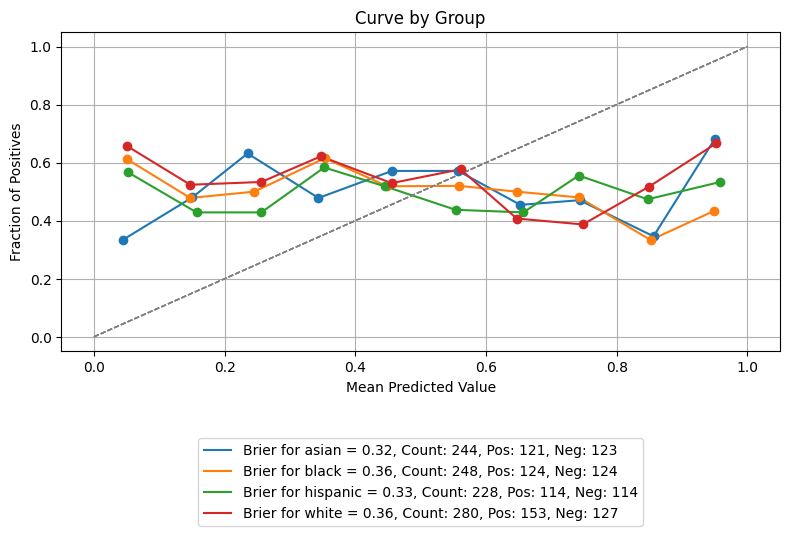

In [7]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    save_path=None,
    filename="group_curve",
    title="Curve by Group",
    # figsize=(4, 4),
    # dpi=100,
    # group="black",
    decimal_places=2,
    # subplots=True,
    n_cols=2,
    n_rows=None,
    color_by_group=True,
    curve_kwgs=None,
    line_kwgs=None,
    n_bins=10,
)

# # Calibration plot
# fig3 = eqb.eq_calibration_curve_plot(
#     data=sliced_data,
#     n_bins=10,
#     title="Calibration Curve by Race",
#     # title=None,
#     # tick_fontsize=8,
#     # group="asian",
#     # subplots=True,
#     n_cols=2,
#     n_rows=1,
#     decimal_places=3,
#     save_path="./images",
# )
# fig3

## Bootstrap Graphs

In [8]:
eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()

eq2.set_fix_seeds(int_list)

print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

data = eq2.slicer("race")
race_metrics = eq2.get_metrics(data)

dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 566.38it/s]

Groups created


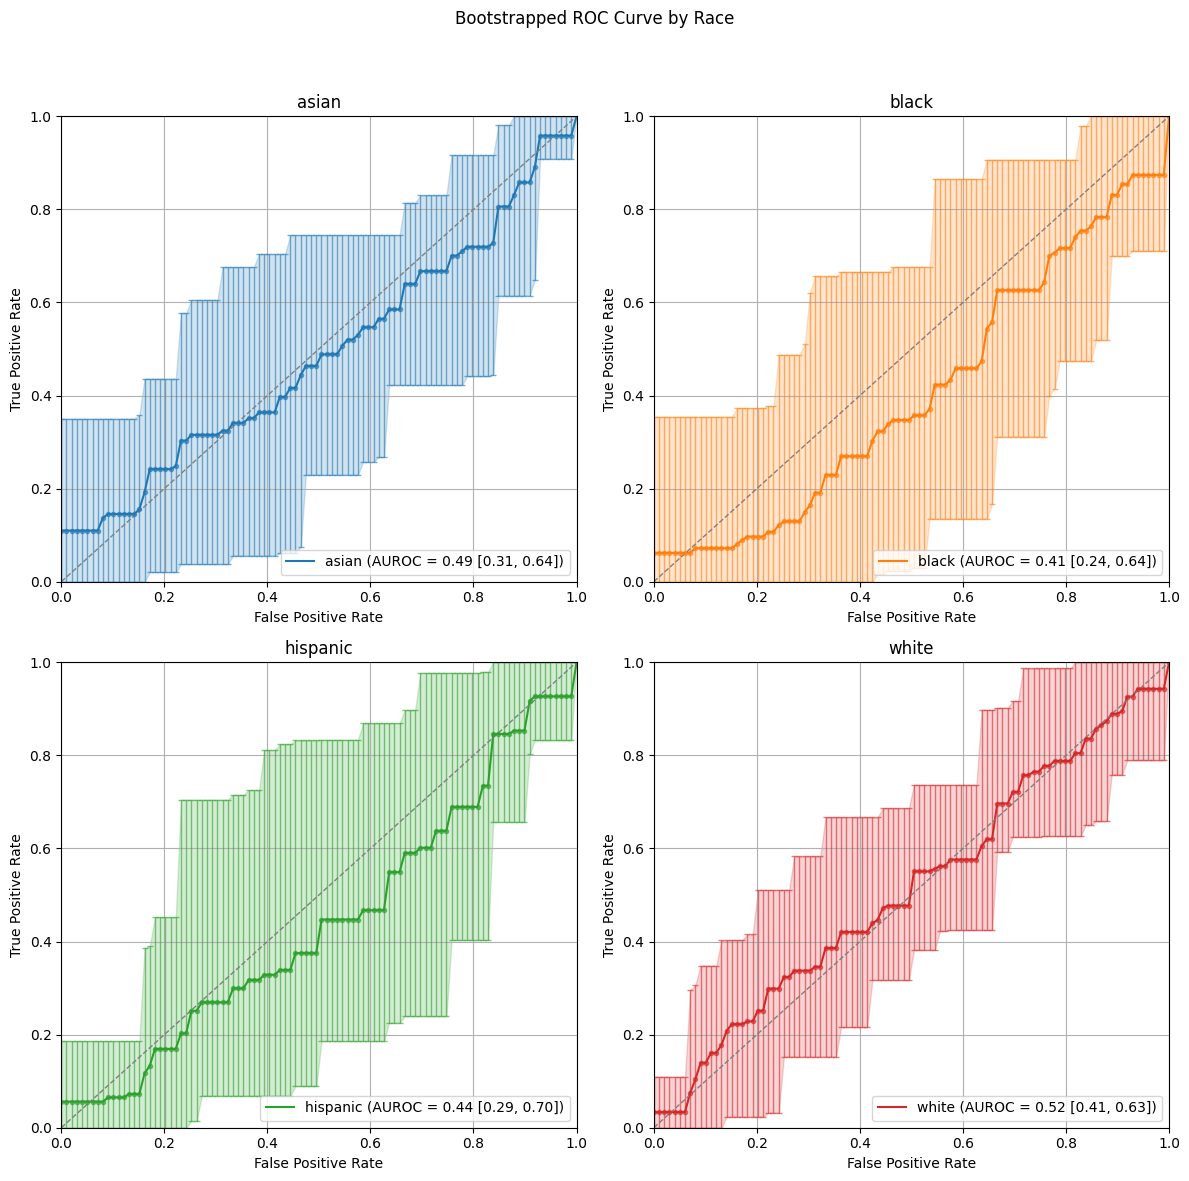

In [9]:
# from equiboots.plots import eq_plot_bootstrapped_group_curves

sliced = eq2.slicer(slicing_var="race")
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="roc",  # or "pr"
    title="Bootstrapped ROC Curve by Race",
    filename="boot_roc_race",
    subplots=True,
    bar_every=100,
    dpi=100,
    n_bins=10,
    figsize=(6, 6),
    color_by_group=True,
)

### Disparity plots

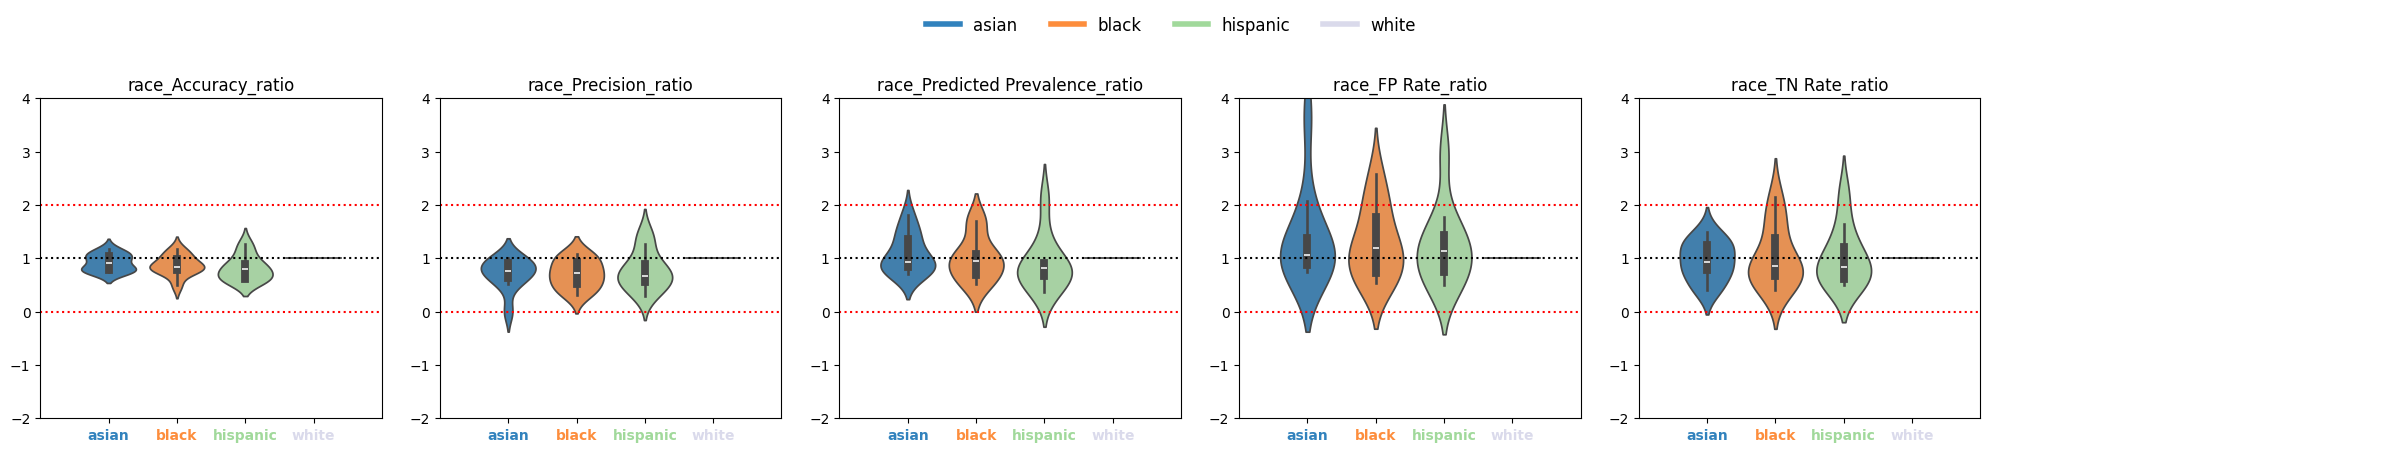

In [10]:
eqb.eq_disparity_metrics_plot(
    dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
    ],
    name="race",
    categories="all",
    figsize=(24, 4),
    plot_kind="violinplot",
    color_by_group=True,
    save_path="./images",
)

### ROCAUC Bootstrap

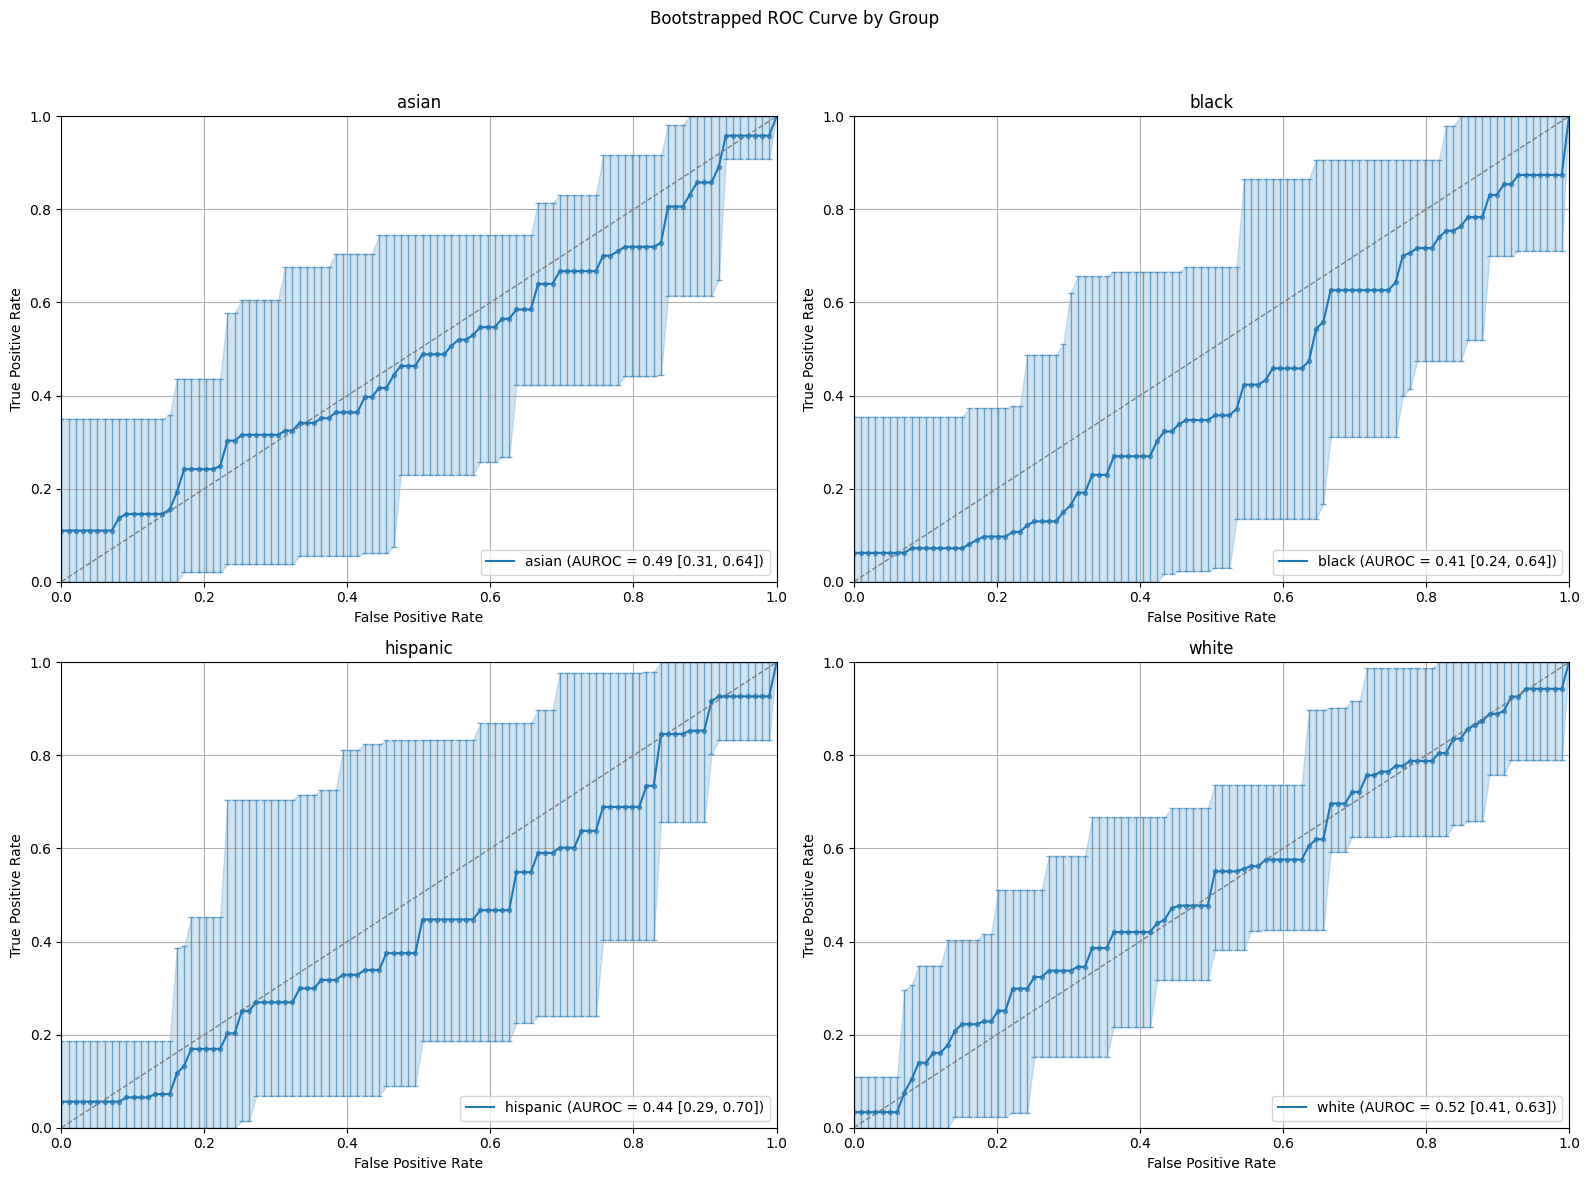

In [11]:
sliced = eq2.slicer(slicing_var="race")
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="roc",  # or "pr"
    title="Bootstrapped ROC Curve by Group",
    filename="boot_roc",
    bar_every=100,
    subplots=True,  # Set to True to see subplots
    color_by_group=False,
)

# from equiboots import eq_plot_bootstrapped_roc_curves

# sliced = eq2.slicer(slicing_var="race")
# eq_plot_bootstrapped_roc_curves(
#     sliced,
#     bar_every=100,
#     subplots=True,
#     # group="black",
#     # n_cols=2,
#     # n_rows=1,
#     figsize=(6, 6),
#     # curve_kwgs={
#     #     "black": {"color": "#FF5733", "alpha": 0.7, "linestyle": "--", "linewidth": 2},
#     #     "white": {"color": "#1F77B4", "alpha": 0.8, "linewidth": 4},``
#     # },
#     show_grid=False,
#     # uniform_color="blue",
#     # fill_kwgs={
#     #     "asian": {"alpha": 0.1, "color": "skyblue", "hatch": "//"},
#     #     "black": {"alpha": 0.2, "color": "salmon", "linewidth": 0.5},
#     # },
#     color_by_group=False,
#     save_path="./images",
# )

In [12]:
sliced_data

{'asian': {'y_true': array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
         0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
         1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
         0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
         1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
         1, 0]),
  'y_prob': array([0.31761725, 0.75799095, 0.17782231, 0.91154751, 0.45692964,
         0.14806366, 0.04925858, 0.7934647 , 0.94600788, 0.9

In [13]:
# plot = eqb.eq_plot_bootstrapped_pr_curves(
#     sliced,
#     bar_every=100,
#     save_path="./images",
#     filename="pr_curves",
#     # group="black"
#     # subplots=True,
# )

In [14]:
# eqb.eq_plot_bootstrapped_calibration_curves(
#     sliced,
#     save_path="./images",
#     # subplots=True,
#     color_by_group=False,
#     subplots=True,
#     # group="black",
#     # line_kwgs={"asian": {"linewidth": 2}},
# )

### Regression Mock-Up

In [15]:
## Generate synthetic regression-like data
np.random.seed(42)
y_true = np.random.normal(loc=50, scale=10, size=1000)  ## continuous target
y_pred = y_true + np.random.normal(
    loc=0, scale=5, size=1000
)  # predicted value with noise

# Not really 'prob', but using this slot for predicted values
y_prob = y_pred

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq3 = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    task="regression",
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq3.grouper(groupings_vars=["race", "sex"])
sliced_data_2 = eq3.slicer("race")

Groups created


## Regression Residuals

/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lshpaner/Documents/GitHub_Repositories/equi_boots/equi_venv_311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lshpaner/Documents/GitHub_Repositorie

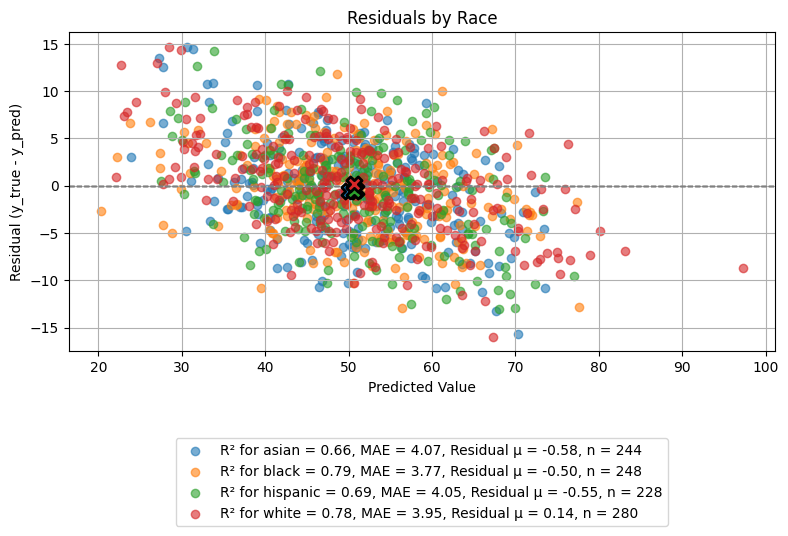

In [16]:
eqb.eq_plot_residuals_by_group(
    data=sliced_data_2,
    # y_true=y_true,
    # y_prob=y_pred,
    # group="black",
    title="Residuals by Race",
    filename="residuals_by_race",
    # subplots=True,
    # group="black",
    color_by_group=True,
    # n_cols=1,
    # n_rows=2,
    figsize=(8, 6),
    show_centroids=True,
    save_path="./images",
)